# Implementation of a Spatiotemporal Self-Attention Based LSTNet

## Imports

In [1]:
import pandas as pd
import yfinance as yf
import tensorflow as tf
import numpy as np
import os
import csv
import keras_tuner
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from scikeras.wrappers import KerasRegressor
from data_processing import DataProcessor
from models.simple_lstm import SimpleLSTM
from models.LSTNet import LSTNet
from datetime import datetime
import matplotlib.pyplot as plt

Using TensorFlow backend


## Data Import and formatting

We are looking to work with multivariate time series data, which will be given to us as a 2D shape: # of timesteps x number of variables. We then need to format this data so that we split it into a train and test set, and use a sliding window approach to divide it into sequences. Then take the last x timesteps in every sequence and make those the labels. We will also of course normalize the data with z-score standardization.

First we will load data. Change the below code block to adjust for data source. Included in this code block should be any variable-specific feature extraction that needs to be down, such as calculating returns from price, etc

In [2]:
raw_data = pd.read_csv("DATA/nasdaq100/small/nasdaq100_padding.csv")

#display info about loaded data
raw_data.info()
raw_data.dropna(inplace=True)

#we need to calculate returns, as this is more useful then the actual price. (price is a function of returns and prev price, so if we know returns we can always calculate price)
#raw_data = DataProcessor.calc_log_returns(raw_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40560 entries, 0 to 40559
Data columns (total 82 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAL     40560 non-null  float64
 1   AAPL    40560 non-null  float64
 2   ADBE    40560 non-null  float64
 3   ADI     40560 non-null  float64
 4   ADP     40560 non-null  float64
 5   ADSK    40560 non-null  float64
 6   AKAM    40560 non-null  float64
 7   ALXN    40560 non-null  float64
 8   AMAT    40560 non-null  float64
 9   AMGN    40560 non-null  float64
 10  AMZN    40560 non-null  float64
 11  ATVI    40560 non-null  float64
 12  AVGO    40560 non-null  float64
 13  BBBY    40560 non-null  float64
 14  BIDU    40560 non-null  float64
 15  BIIB    40560 non-null  float64
 16  CA      40560 non-null  float64
 17  CELG    40560 non-null  float64
 18  CERN    40560 non-null  float64
 19  CMCSA   40560 non-null  float64
 20  COST    40560 non-null  float64
 21  CSCO    40560 non-null  float64
 22

Then we do a train/test split, create sequences with sliding window, normalize data, and designate labels(what we are trying to predict). The length of each sequence is set by SEQ_LEN.

One question here is whether to normalize the target values. In other words, should we normalize data and then split the time series in to features and labels, or split first and then only normalize features. From past work, ~~I have seen better Mean Average Percent Error (MAPE) by doing the former, but intuition says it shouldn't matter.~~ From some reading, I have learned that normalizing all data, and not just the features, is a form of train-test contamination, as it allows some information from the test set to be encoded in the train set. Only features should be normalized. 

We also need to deal with missing values. For now, we will just drop the rows (timesteps) that have missing values but I think we should further consider the effects of this later down the line.

In [3]:
SEQ_LEN = 20

train_data, test_data = train_test_split(raw_data, test_size=0.3, shuffle=False) #it is imporant the data is not shuffled here, since this is time series data

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

val_data, test_data = train_test_split(test_data, test_size=0.2, shuffle=False)

train_sequences = DataProcessor.sliding_window_sequence(train_data, SEQ_LEN)
test_sequences = DataProcessor.sliding_window_sequence(val_data, SEQ_LEN)

train_x, train_y = DataProcessor.sequence_target_split(train_sequences, target_size=1)
test_x, test_y = DataProcessor.sequence_target_split(test_sequences, target_size=1)

train_x = DataProcessor.zscore_standardization(train_x)
test_x = DataProcessor.zscore_standardization(test_x)

We then need to convert this multiIndex DataFrame we have into a 3 dimensional numpy to feed into the model. Each of x_train, x_test, y_train, y_test will have the 3D shape num_sequences x timesteps_per_sequence x num_variables. For our y-values, we will only predict one timestep in the future for now, for simplicity's sake.

In [4]:
x_train = DataProcessor.fold_sequences(train_x)
x_test = DataProcessor.fold_sequences(test_x)
y_train = DataProcessor.fold_sequences(train_y)
y_test = DataProcessor.fold_sequences(test_y)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(28373, 19, 82)
(9715, 19, 82)
(28373, 82)
(9715, 82)


We also likely only want to predict one of the time series variables, so we can select which one we want that to be. In the code block below, choose the index of the variable to be selected.

In [5]:
Y_VAR = 1   #index of variable to be predicted

y_train = y_train[:,Y_VAR]
y_test = y_test[:,Y_VAR]

## Model Initialization

We create a short function to build the model, and set it up for a training run.

In [6]:
def build_model(hp):

    #change the model to run here
    model = SimpleLSTM(hp)
    model.build(x_train.shape)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.mean_absolute_error] 
    )

    return model

## Hyperparameter Optimization

Optionally, We will run a hyperparameter optimization on the model to find the best hyperparameters.

In [7]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mean_absolute_error",
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="HP_OPTIMIZATION_LOGS"
)

hparam_optimize = False #change to false if want to use default hp

if hparam_optimize:

    print("Running hyperparameter optimization")
    tuner.search_space_summary()

    tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

    hparams = tuner.get_best_hyperparameters(1)[0]

else:

    hparams = keras_tuner.HyperParameters()

## Training

Now that we have our data properly formatted and hyperparameters decided, we will reinitialize the model with the chosen hyperparameters, train it, and test it. Please change the name of the model to be appropriate, as this name is used as a filename for saving the model.

In [8]:
model = build_model(hparams)
print(model.summary())

model_path = "SAVED_MODELS/{ts}".format(ts=datetime.now()).replace(" ", "-").replace(":", "-").split(".")[0]
os.mkdir(model_path)

checkpoint_path = "{modelPath}/{mn}.ckpt".format(modelPath=model_path, mn=model.name)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

EPOCHS = 5
BATCH_SIZE = 32

#train
train_hist = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    callbacks=[cp_callback],
    shuffle=False
)

#write to training log
log_entry = [
    model.name,
    model_path,
    EPOCHS,
    BATCH_SIZE,
    train_hist.history["val_mean_absolute_error"][-1]
]

with open('SAVED_MODELS/training_log.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(log_entry)

Model: "simpleLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             multiple                  129       
                                                                 
 lstm_2 (LSTM)               multiple                  131584    
                                                                 
 lstm_3 (LSTM)               multiple                  108032    
                                                                 
Total params: 239,745
Trainable params: 239,745
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1774/1774 [==============================] - ETA: 0s - loss: 5715.5122 - mean_absolute_error: 52.5380
Epoch 1: saving model to SAVED_MODELS/2023-10-30-15-29-11\simpleLSTM.ckpt
1774/1774 [==============================] - 863s 483ms/step - loss: 5715.5122 - mean_absolute_error: 52.5380 - val_loss: 3

## Testing

The below code is for testing and visualization.

76/76 [==============================] - 3s 45ms/step


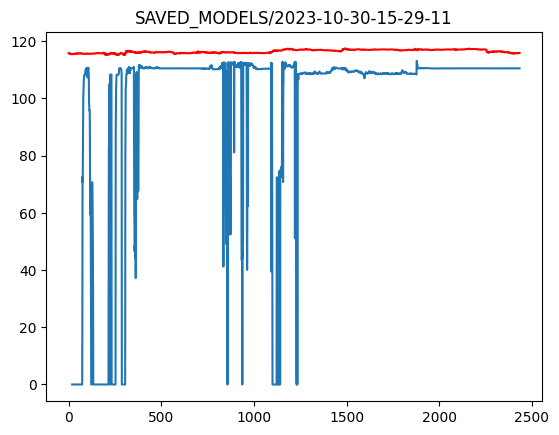

In [12]:
#make sequences, x/y split, normalize, and fold
td = DataProcessor.sequence_target_split(DataProcessor.sliding_window_sequence(test_data, SEQ_LEN), target_size=1)[0]
td = DataProcessor.fold_sequences(DataProcessor.zscore_standardization(td))

predicted_var = test_data.to_numpy()[:,Y_VAR]

plt.plot(np.arange(0, predicted_var.shape[0]), predicted_var, 'red')
plt.plot(np.arange(SEQ_LEN - 1, predicted_var.shape[0]), model.predict(td).reshape(td.shape[0])), 'blue'
plt.title(model_path)

plt.show()